In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,8]

## 1. Line detecting and template creating

Outcome of this process is detecting the box of every individual pokemon. Then it's possible to crop it and used it as template for template matching

### 1.1 Load demo source

In [3]:
img = cv2.imread("img/pikachu_board_1.png")

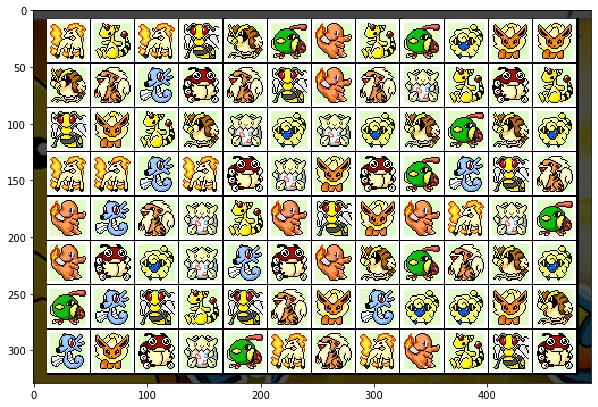

In [4]:
plt.imshow(img[:,:,::-1])

At this point, 3 channels color is unnecessary because gray channel was contained all the information we may need.

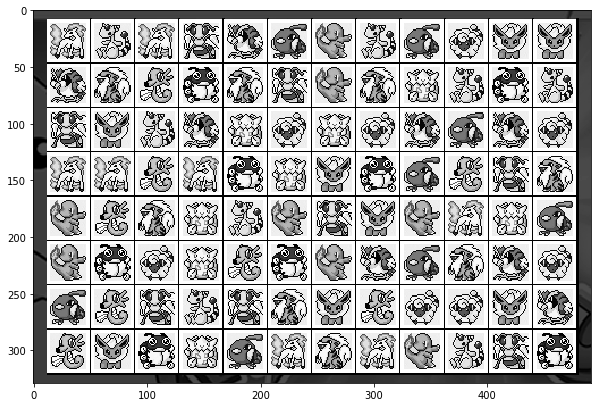

In [5]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap = "gray")

### 1.2 Using Canny for *edge detecting*

`Canny(...)`

***Canny(image, threshold1, threshold2[, edges[, apertureSize[, L2gradient]]])*** -> edges

*Note: For more detail about Canny, check in: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html*

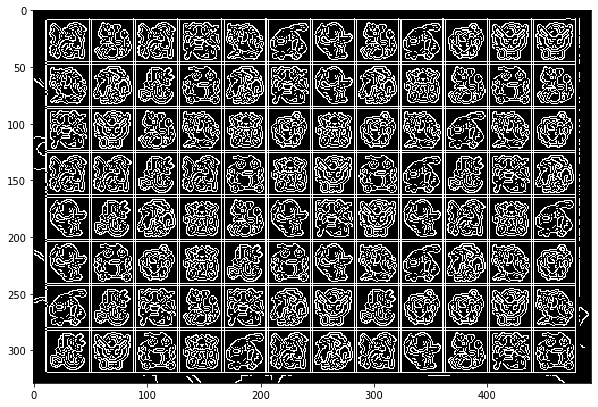

In [6]:
edge_detecting = cv2.Canny(gray_img, 200, 240, 30)
plt.imshow(edge_detecting, cmap='gray')

### 1.3 Using *HoughLine* transform to detecting strange line

`HoughLinesP(...)`

***HoughLinesP(image, rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]])*** -> lines

*Note: For more detail about Canny, check in: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html?highlight=houghlinesp*

In [7]:
copy = img.copy()
linesP = cv2.HoughLinesP(edge_detecting, 1, np.pi/180, 250, None, 50, 15)

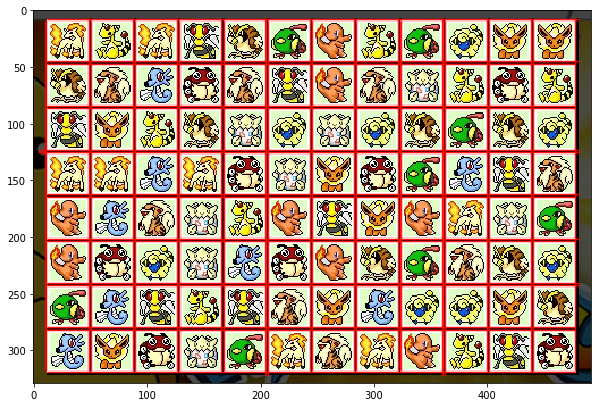

In [8]:
for i in range(0, len(linesP)):
    l = linesP[i][0]
    cv2.line(copy, (l[0], l[1]), (l[2], l[3]), (0,0,255), 1, cv2.LINE_AA)
    plt.imshow(copy[...,::-1])

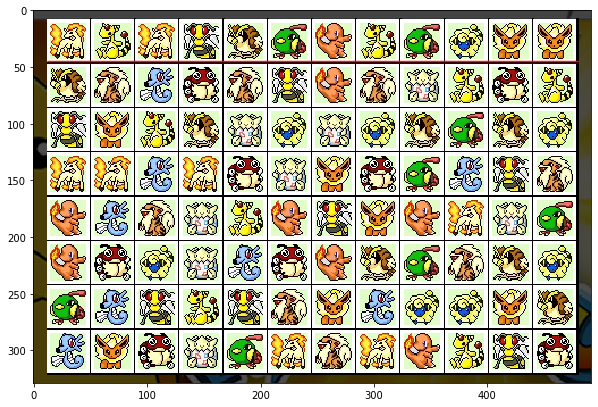

In [9]:
#demo selecting a random line
l = linesP[3][0]
copy = img.copy()
cv2.line(copy, (l[0], l[1]), (l[2], l[3]), (0,0,255), 1, cv2.LINE_AA)
plt.imshow(copy[...,::-1])

### 1.4 Horizontal and vertical line classification

In [10]:
horizontal_lines = []
vertical_lines = []

for i in range(0, len(linesP)):
    l = linesP[i][0]
    if (l[0] == l[2]):
        vertical_lines.append(l)
    elif (l[1] == l[3]):
        horizontal_lines.append(l);

In [11]:
print(f"Number of horizontal lines: {len(horizontal_lines)}")
print(f"Number of vertical lines: {len(vertical_lines)}")

width = int(len(vertical_lines)/2)
height = int(len(horizontal_lines)/2)

Number of horizontal lines: 16
Number of vertical lines: 24


We see that all lines are either horizontal or vertical.

Now we will sort horizontal lines list and vertical lines list to create some order.

In [12]:
def hori(l):
    return l[1]
horizontal_lines.sort(key = hori)

def verti(l):
    return l[0]
vertical_lines.sort(key = verti)

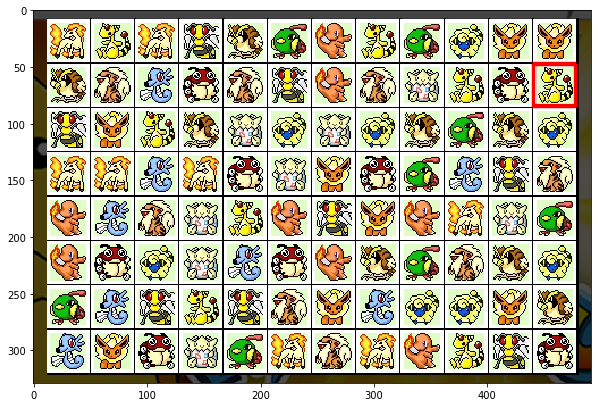

In [13]:
#demo select a random pokemon
top_left = (vertical_lines[22][0], horizontal_lines[2][1])
bottom_right = (vertical_lines[23][0], horizontal_lines[3][1])

copy = img.copy()
cv2.rectangle(copy, top_left, bottom_right, (0,0,255), 2, cv2.LINE_AA)
plt.imshow(copy[...,::-1])

### 1.5 Detecting similar pokemon

Firstly, let's create template and put them in a list!

In [14]:
pokemons = []
for index in range(height):
    pokemon = []
    for jndex in range(width):
        top_left = (vertical_lines[jndex*2][0], horizontal_lines[index * 2][1])
        bottom_right = (vertical_lines[jndex*2 + 1][0], horizontal_lines[index * 2 + 1][1])
        pokemon.append((top_left, bottom_right))
    pokemons.append(pokemon)

print(f"row: {len(pokemons)}, col: {len(pokemons[0])}")

row: 8, col: 12


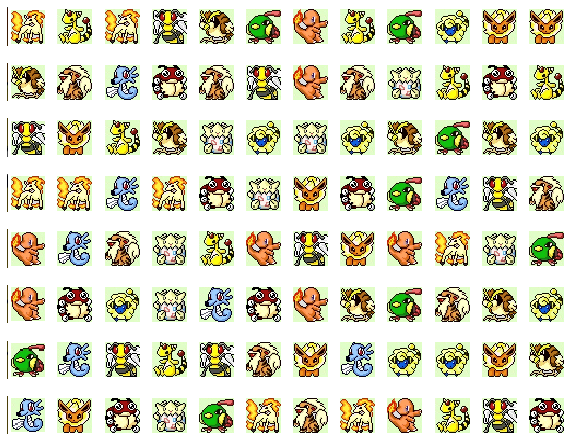

In [15]:
fig, ax = plt.subplots(height, width)
plt.rcParams['figure.figsize'] = [12,8]
for index in range(height):
    for jndex in range(width):
        top_left, bottom_right = pokemons[index][jndex][0],  pokemons[index][jndex][1]
        template = img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
        ax[index][jndex].axis('off')
        ax[index][jndex].imshow(template[:,:,::-1])

### 1.6 Using template matching to locate bag of similar Pokemon

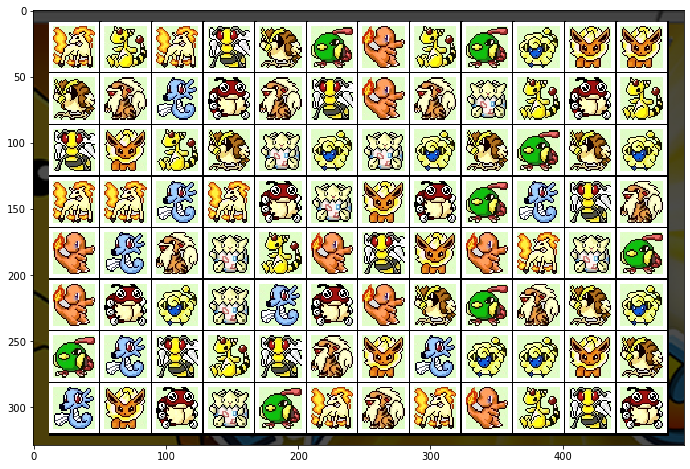

In [16]:
plt.imshow(img[:,:,::-1])

#### Template matching and visuallize result function

In [17]:
def detectingPokemon(img, template, meth="cv2.TM_CCORR"):
    method = eval(meth)
    if len(img.shape) == 3:
        b, r, g = cv2.split(img)
        temp_b, temp_r, temp_g = cv2.split(template)
        
        res_b = cv2.matchTemplate(b, temp_b, method)
        res_r = cv2.matchTemplate(r, temp_r, method)
        res_g = cv2.matchTemplate(g, temp_g, method)
        res = np.add(res_b, res_r, res_g)
    else: 
        print("The input image have only gray channel")
        return
    
    return res

In [18]:
def display(img, top_left_origin, bottom_right_origin, res, verbo = False):
    template = img[top_left_origin[1]:bottom_right_origin[1], top_left_origin[0]:bottom_right_origin[0]]
    h, w, c = template.shape
    res_height, res_width = res.shape
    
    max_val = np.amax(res)
    locs = []
    
    threshold = 0.97
    #selecting points which have value equal or bigger than max_val
    for index in range(res_height):
        for jndex in range(res_width):
            if res[index][jndex] >= threshold*max_val:
                locs.append((jndex, index))
                
    #Every single Pokemon can be indentify if we have top_left point and bottom_left point.
    #This double loof return a list name "locs" which have might be the Pokemon we are looking for.
    
    #Todo: Later we need to find each Pokemon their siblings, that can be done with for all the Pokemon. Hmmm, it might takes a long time
    if verbo:
        print("Location of similar Pokemon: ", locs)

        img_copy = img.copy()

        #loop for every single one who have the same value as max point
        for loc in locs:
            top_left = loc
            bottom_right = ((loc[0] + w), (loc[1] + h))
            cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 2)

        cv2.rectangle(img_copy, top_left_origin, bottom_right_origin, (0, 0, 255), 2)
        plt.axis('off')
        plt.imshow(img_copy[:,:,::-1])
    
    return locs

### Demo simple pokemon

I'm taking the first pokemon of the board which location in [0, 0]

'Cause we have cropped all the pokemon, so I just have to take the `top_left` and `bottom_right` of the its from `pokemons` to became its own template for template matching algorithm above

In this case, I'm using TM_CCORR with 3 channels color. Good result confirmed!

In [19]:
#demo with a random Pokemon

top_left, bottom_right = pokemons[0][0][0],  pokemons[0][0][1]
template = img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

start_time = time.time()
demo_res = detectingPokemon(img, template)

print(f"Time for each template matching: {time.time()-start_time} s")

Time for each template matching: 0.38039350509643555 s


At function `detectingPokemon`, I've already create a list name `locs` contains all the position which have the value approximately equal to the max value

Location of similar Pokemon:  [(11, 9), (89, 9), (11, 126), (50, 126), (128, 126), (362, 165), (206, 282), (284, 282)]


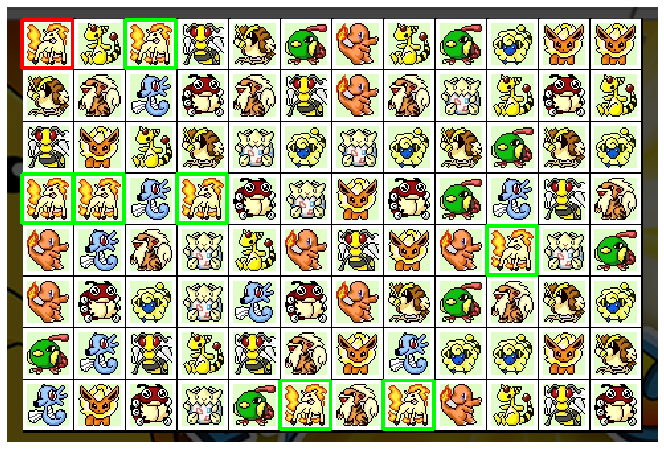

In [20]:
#display test result
#red box presents the current position, green boxs present all the same pokemon
similar_locs = display(img, top_left, bottom_right, demo_res, verbo = True)

## 2. Let's play!

### 2.1 Build a logical Pikachu Board from an image of Pokemon Game

#### Pixel position & logical position mapping

First we will do a demo of mapping a pixel position to logical position.

Input: all pixel locations of pokemon cards after template matching with pokemon[0][0] as the template.

Output: logical positions of all the inputs.

In [21]:
width_gap = vertical_lines[2][0] - vertical_lines[1][0]
print(f"Width gap: {width_gap}")

Width gap: 2


In [22]:
height_gap = horizontal_lines[2][1] - horizontal_lines[1][1]
print(f"Height gap: {height_gap}")

Height gap: 2


In [23]:
width_pokemon = abs(pokemons[0][0][0][0] - pokemons[0][0][1][0])
height_pokemon = abs(pokemons[0][0][0][1] - pokemons[0][0][1][1])
print(f"Width Pokemon: {width_pokemon}")
print(f"Height Pokemon: {height_pokemon}")

Width Pokemon: 38
Height Pokemon: 37


In [24]:
x_origin = pokemons[0][0][0][0]
y_origin = pokemons[0][0][0][1]
print(x_origin, y_origin)

11 9


In [25]:
x_similar_pokemon = similar_locs[2][0]
y_similar_pokemon = similar_locs[2][1]
print(f"x of similar Pokemons: {x_similar_pokemon}")
print(f"y of similar Pokemons: {y_similar_pokemon}")

x of similar Pokemons: 11
y of similar Pokemons: 126


In [26]:
#Determine the column position
x_distance_from_origin = x_similar_pokemon - x_origin
total_width = width_gap + width_pokemon
col_idx = math.floor((x_distance_from_origin + total_width / 2)/total_width)
print(f"column index: {col_idx}")

column index: 0


In [27]:
#Determine the row position
y_distance_from_origin = y_similar_pokemon - y_origin
total_height = height_gap + height_pokemon
row_idx = math.floor((y_distance_from_origin + total_height / 2)/total_height)
print(f"row index: {row_idx}")

row index: 3


In [28]:
#Determine the logical position of all the pokemons.
logical_positions = []
for location in similar_locs:
    x_similar_pokemon = location[0]
    y_similar_pokemon = location[1]
    #Determine the row position
    y_distance_from_origin = y_similar_pokemon - y_origin
    total_height = height_gap + height_pokemon
    row_idx = math.floor((y_distance_from_origin + total_height / 2)/total_height)
    #Determine the column position
    x_distance_from_origin = x_similar_pokemon - x_origin
    total_width = width_gap + width_pokemon
    col_idx = math.floor((x_distance_from_origin + total_width / 2)/total_width)
    logical_positions.append((row_idx, col_idx))

In [29]:
print(logical_positions)

[(0, 0), (0, 2), (3, 0), (3, 1), (3, 3), (4, 9), (7, 5), (7, 7)]


#### Bring it all together and create logical boards.

In [30]:
#Initialize a list with size of Pikachu Board
pika_board = np.zeros((len(pokemons), len(pokemons[0])))

In [31]:
#Indexing similar pokemons with the same number as the template

def idx_similar_pokemon(positions, index, pika_board):
    for position in positions:
        pika_board[position[0], position[1]] = index

In [32]:
#Find pixel position of similar pokemon

def find_similar_pixPos(row_original, col_original, pokemons, img):
    top_left, bottom_right = pokemons[row_original][col_original][0],  pokemons[row_original][col_original][1]
    template = img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
    demo_res = detectingPokemon(img, template)
    similar_locs = display(img, top_left, bottom_right, demo_res, verbo = False)
    return similar_locs
    

In [33]:
def find_logical_position(similar_locs, pokemons, width_gap, height_gap):
    #determine width and height of each pokemon
    width_pokemon = abs(pokemons[0][0][0][0] - pokemons[0][0][1][0])
    height_pokemon = abs(pokemons[0][0][0][1] - pokemons[0][0][1][1])
    #determine top left corner of the pokemon board
    x_origin = pokemons[0][0][0][0]
    y_origin = pokemons[0][0][0][1]
    #Determine the logical position of all the pokemons.
    logical_positions = []
    for location in similar_locs:
        x_similar_pokemon = location[0]
        y_similar_pokemon = location[1]
        #Determine the row position
        y_distance_from_origin = y_similar_pokemon - y_origin
        total_height = height_gap + height_pokemon
        row_idx = math.floor((y_distance_from_origin + total_height / 2)/total_height)
        #Determine the column position
        x_distance_from_origin = x_similar_pokemon - x_origin
        total_width = width_gap + width_pokemon
        col_idx = math.floor((x_distance_from_origin + total_width / 2)/total_width)
        logical_positions.append((row_idx, col_idx))
    return logical_positions
    

In [34]:
index = 1

for row in range(len(pika_board)):
    for col in range(len(pika_board)):
        #check if the position has been indexed or not
        if (pika_board[row, col] != 0):
            continue
        #index the position
        pika_board[row, col] = index
        
        #find similar pokemon and index
        
        similar_locs = find_similar_pixPos(row, col, pokemons, img)
        logical_positions = find_logical_position(similar_locs, pokemons, width_gap = width_gap, height_gap = height_gap)
        idx_similar_pokemon(logical_positions, index, pika_board)
        
        #update index
        index += 1
        
        
        

In [35]:
print(pika_board)

[[ 1.  2.  1.  3.  4.  5.  6.  2.  5. 12. 10. 10.]
 [ 4.  7.  8.  9.  7.  3.  6.  7. 11.  2.  9.  2.]
 [ 3. 10.  2.  4. 11. 12. 11. 12.  4.  5.  4. 12.]
 [ 1.  1.  8.  1.  9. 11. 10.  9.  5.  8.  3.  7.]
 [ 6.  8.  7. 11.  2.  6.  3. 10.  6.  1. 11.  5.]
 [ 6.  9. 12. 11.  8.  9.  6.  4.  5.  7.  4. 12.]
 [ 5.  8.  3.  2.  3.  7. 10.  8. 12. 12. 10.  4.]
 [ 8. 10.  9. 11.  5.  1.  7.  1.  6.  2.  3.  9.]]


### 2.2 Pikachu Solver

#### Detect and find path between 2 matched Pokemons

First we will pad the Pokemon board with zeros.

In [36]:
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

pika_board = np.pad(pika_board, 1, pad_with, padder=0)
pika_board

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  1.,  2.,  1.,  3.,  4.,  5.,  6.,  2.,  5., 12., 10., 10.,
         0.],
       [ 0.,  4.,  7.,  8.,  9.,  7.,  3.,  6.,  7., 11.,  2.,  9.,  2.,
         0.],
       [ 0.,  3., 10.,  2.,  4., 11., 12., 11., 12.,  4.,  5.,  4., 12.,
         0.],
       [ 0.,  1.,  1.,  8.,  1.,  9., 11., 10.,  9.,  5.,  8.,  3.,  7.,
         0.],
       [ 0.,  6.,  8.,  7., 11.,  2.,  6.,  3., 10.,  6.,  1., 11.,  5.,
         0.],
       [ 0.,  6.,  9., 12., 11.,  8.,  9.,  6.,  4.,  5.,  7.,  4., 12.,
         0.],
       [ 0.,  5.,  8.,  3.,  2.,  3.,  7., 10.,  8., 12., 12., 10.,  4.,
         0.],
       [ 0.,  8., 10.,  9., 11.,  5.,  1.,  7.,  1.,  6.,  2.,  3.,  9.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]])

Algorithm to detect and find path between Pokemons.

In [43]:
import collections
import numpy as np
import time

def bfs4(board):
    n = board.shape[0]
    m = board.shape[1]
    for i in range(1, n-1):
        for j in range(1, m-1):
            # check if pokemon or empty cell
            if board[i,j] > 0:
                answer = bfs4_cell(board, n, m, i, j)
                # if found a way to match 2 pokemons, return an array of tuples denoting the cells along the path
                if answer != -1:
                    return answer
    return -1


def bfs4_cell(board, n, m, sx, sy):
    limit_cost = 2
    dx = [0, 1, 0, -1]
    dy = [1, 0, -1, 0]
    de = collections.deque([(sx, sy, 0), (sx, sy, 1), (sx, sy, 2), (sx, sy, 3)])
    d = np.zeros((n, m, 4), dtype=int)
    trace = np.zeros((n, m, 4, 3), dtype=int)
    visited = np.zeros((n, m, 4), dtype=bool)
    while de:
        cur = de.pop()
        if visited[cur[0],cur[1],cur[2]] == True:
            continue
        visited[cur[0],cur[1],cur[2]] = True
        # bfs in 4 directions
        for i in range(4):
            if (i+2)%4==cur[2]:
                continue
            next_x = cur[0] + dx[i]
            next_y = cur[1] + dy[i]
            # check if cell is outside the board or already visited
            if next_x < 0 or next_x >= n or next_y < 0 or next_y >= m or visited[next_x,next_y,i] == True:
                continue
            cost = d[cur[0],cur[1],cur[2]]
            change_direction = (cur[2] != i)
            # check if number of direction changes exceeds limit 
            if cost + change_direction > limit_cost:
                continue
            d[next_x,next_y,i] = cost + change_direction # fix cost
            trace[next_x,next_y,i,:] = cur
            if board[next_x,next_y] == board[sx,sy]:
                # solution found
                answer = [(next_x, next_y)]
                cur_direction = i
                while next_x != sx or next_y != sy:   
                    prev_x, prev_y, prev_dir = trace[next_x,next_y,cur_direction]
                    answer.append((prev_x, prev_y))
                    next_x, next_y, cur_direction = prev_x, prev_y, prev_dir
#                 print(d)
                return answer[::-1]
            elif board[next_x,next_y] == 0:
                if change_direction == 0:
                    de.append((next_x, next_y, i))
                else:
                    de.appendleft((next_x, next_y, i))
    return -1

In [45]:
bfs4_cell(pika_board, pika_board.shape[0], pika_board.shape[1], 1, 2)

[(1, 2), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 8)]

### 2.2 Time to solve Pikachu

In [56]:
steps = []
states = []
pika_state = pika_board.copy()
while(True):
    states.append(pika_state)
    step = bfs4(pika_state)
    if step == -1:
        break
    steps.append(step)
    first_point = step[0]
    second_point = step[-1]
    pika_state[first_point[0], first_point[1]] = 0
    pika_state[second_point[0], second_point[1]] = 0
    states.append(pika_state)
    

In [57]:
print(steps[-1])

[(8, 6), (8, 7), (8, 8)]
